In [ ]:
import ms_analysis as msa

In [ ]:
mc = msa.MSout("../ms_out/pH7eH0ms.txt")

In [ ]:
ms_orig_lst = [[ms.E, ms.count, ms.state] for  ms in list((mc.microstates.values()))]
ms_orig_lst = sorted(ms_orig_lst, key = lambda x:x[0])


In [ ]:
Total_count = sum([x[1] for x in ms_orig_lst])
print(Total_count)

In [ ]:
# This will convert the charge microstate id to charge id.
id_vs_charge = {}
for conf in msa.conformers:
    id_vs_charge[conf.iconf] = conf.crg

def convert_ms_crg(l, d):
    crg_lst =[[y[0], y[1], [convert_ms_crg(x, d) if isinstance(x, list) else d.get(x, x) for x in y[2]]] for y in l]
    return crg_lst

crg_orig_lst = convert_ms_crg(ms_orig_lst, id_vs_charge )


In [ ]:
#  plot the enthalpy distribution and energy count distribution
# lets flatten the list
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
energy_lst_count =np.asarray([a for a,f in zip([x[0] for x in crg_orig_lst], [x[1] for x in crg_orig_lst]) for _ in range(f)])
energy_lst = np.asarray([x[0] for  x in crg_orig_lst])

fig = plt.figure(figsize = (12,6))
fig.suptitle("4lzt at pH7")

plt.subplot(121)
plt.title(' Total Count (MC)')
sns.histplot(energy_lst_count,binwidth=2, kde = True)
plt.xlabel(" Enthalpy (Kcal/Mol)")


plt.subplot(122)
sns.histplot(energy_lst, binwidth=2)
plt.title('No Count from MC')
plt.xlabel(" Enthalpy (Kcal/Mol)")
fig.savefig("enthalpy_dis.pdf", dpi = 600, bbox_inches = "tight")

In [ ]:
# This will make a free residues list.
import pandas as pd
free_residues = []
for res in mc.free_residues:
    free_residues.append(msa.conformers[res[0]].resid)
ms_free_residues = pd.DataFrame(free_residues,columns = ["Residue"])
ms_free_residues


In [ ]:
# This will make the fixed ionizable residues list.
fixed_resid = []
for conf in msa.conformers:
    if conf.resid not in free_residues:
        if conf.resid[:3] == "NTR" or conf.resid[:3] == "CTR" or conf.resid[:3] == "HIS" or conf.resid[:3] == "LYS" or conf.resid[:3] == "ARG" or conf.resid[:3] == "CYS" or conf.resid[:3] == "ASP" or conf.resid[:3] == "GLU" or conf.resid[:3] == "TYR":
            if conf.resid not in fixed_resid:
                fixed_resid.append(conf.resid)
    
print(fixed_resid[:3])

In [ ]:
# This will read the back ground charge i.e. not appearing in microstate file.
def read_backcrg(fname, ph):
    fixed_resid_vs_crg = {} 
    lines = open(fname).readlines()[:-4]
    headline = lines.pop(0)
    fields = headline.split()
    t_type = fields[0].strip()
    t_points = [float(x) for x in fields[1:]]
    index_ph = t_points.index(float(ph)) + 1
    for line in lines:
        fields = line.split()
        if (fields[0][:3] + fields[0][4:]) in fixed_resid:
            fixed_resid_vs_crg[(fields[0][:3] + fields[0][4:])] = round(float(fields[index_ph]), 0)
    back_crg= round(sum(list(fixed_resid_vs_crg.values())),0)

    return back_crg, fixed_resid_vs_crg

# Select proper ph here

In [ ]:
# make sure give the same ph value you used to read the ms file
fixed_sum_crg = read_backcrg("../sum_crg.out", 7)
print(fixed_sum_crg[1])
print(fixed_sum_crg[0])
# THis will make the charge information of fixed residues for MD simulation.
fixed_residues_crg = pd.DataFrame(fixed_sum_crg[1].items(), columns=['Residue', 'crg'])
fixed_residues_crg

In [ ]:
# This will find the unique charge of all charge microstate. Three unique charge state with highest count will select for MD.
# This will add to the dictionary value and make a list of enthalpy with maximum and minimum value
crg_all_count = {}
for array in crg_orig_lst:
    if tuple(array[2]) not in crg_all_count.keys():
        crg_all_count[(tuple(array[2]))] = [array[1], [array[0]]]
        
    else:
        crg_all_count[(tuple(array[2]))][0] += array[1]
        if len(crg_all_count[(tuple(array[2]))][1]) == 1:
            
            if array[0] < crg_all_count[(tuple(array[2]))][1][0]:
                crg_all_count[(tuple(array[2]))][1].insert(0, array[0])
                
            
            else:
                crg_all_count[(tuple(array[2]))][1].append(array[0])
                
        else:
            if array[0] < crg_all_count[(tuple(array[2]))][1][0]:
                del crg_all_count[(tuple(array[2]))][1][0]
                crg_all_count[(tuple(array[2]))][1].insert(0, array[0])
            elif array[0] > crg_all_count[(tuple(array[2]))][1][-1]:
                crg_all_count[(tuple(array[2]))][1].pop()
                crg_all_count[(tuple(array[2]))][1].append(array[0])
            else:
                continue
                
# make a list of count and charge microstate
all_crg_ms_unique  = []
all_count = []
energy_diff_all = []
for u,v in crg_all_count.items():
    all_crg_ms_unique.append(list(u))
    all_count.append(v[0])
    if len(v[1]) == 2:
        energy_diff_all.append(round(v[1][1]-v[1][0], 6))
    elif len(v[1]) == 1:
        energy_diff_all.append(0)
    else:
        print("error in dictionary")
print(len(all_crg_ms_unique) == len(energy_diff_all) == len(all_count))   
print(f" Total charge ms : {len(crg_orig_lst )}, Total Unique charge ms  {len(all_crg_ms_unique)}")              
# make the panda data frame and concatinate
# make panda series and save
import pandas as pd
all_crg_ms_lst = pd.DataFrame(all_crg_ms_unique).T
all_ms_count = pd.DataFrame(all_count,columns = ["Count"]).T
all_crg_ms_count_pd = pd.concat([all_crg_ms_lst.reindex(all_crg_ms_lst.index), all_ms_count])
all_crg_count_res_1 = pd.concat([ms_free_residues, all_crg_ms_count_pd.reindex(all_crg_ms_count_pd.index)], axis=1)
from numpy import inf
all_crg_count_res_1 = all_crg_count_res_1.fillna('Count')
# remove the non titrable residues
all_crg_count_res = all_crg_count_res_1.copy()
for x,y in all_crg_count_res.iterrows():
    if y['Residue'][:3] != "NTR" and y['Residue'][:3] != "CTR" and y['Residue'][:5] != "Count" and y['Residue'][:3] != "ASP" and y['Residue'][:3] != "GLU"\
       and y['Residue'][:3] != "LYS" and y['Residue'][:3] != "TYR" and  y['Residue'][:3] != "ARG" and y['Residue'][:3] != "CYS"and y['Residue'][:3] != "HIS":
        
        all_crg_count_res.drop([x], inplace = True)

all_crg_count_res = all_crg_count_res.set_index("Residue")
# sort based on the count
all_crg_count_res = all_crg_count_res.sort_values(by = "Count", axis = 1, ascending = False)


In [ ]:
# which tautomer charge state is most populated. This includes the background charge also.
# which tautomer charge state is most populated. This includes the background charge also.
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline
x_av = [sum(x) + fixed_sum_crg[0] for x in all_crg_ms_unique]
y_av = [math.log10(x) for x in all_count]
energy_diff_all_fl = [float(x) for x in energy_diff_all]
g1 = sns.JointGrid(marginal_ticks=True, height = 6)
ax = sns.scatterplot(x=x_av, y=y_av, hue = energy_diff_all_fl, palette = 'viridis', size = energy_diff_all_fl, sizes=(10, 200), ax=g1.ax_joint)
ax.set_xticks(range(int(min(x_av)), int(max(x_av)) + 1))
ax.set_xlabel("Charge",fontsize=15)
ax.set_ylabel("log$_{10}$(Count)",fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax2 = sns.histplot(x=x_av, linewidth=2,discrete=True, ax=g1.ax_marg_x)

ax2.set_ylabel(None,fontsize=16)
g1.ax_marg_y.set_axis_off()
g1.fig.subplots_adjust(top= 0.9)
g1.fig.suptitle('Whole Enthalpy(4lzt)_pH7', fontsize = 16)
g1.savefig("all_en_cr_ph7_vs_log(count).pdf", dpi = 600, bbox_inches = "tight")


In [ ]:
#find the  10 lowest energy microstate and make unique
# This is for 1KT unit(1.36 Kcal/Mol) near to lowest energy regions
#low_crg_ms = crg_orig_lst[:10]
low_crg_ms = [[x[0], x[1], x[2]] for x in crg_orig_lst if x[0] <= (mc.lowest_E  + 1.36)]

low_crg_count = {}
for array in low_crg_ms :
    if tuple(array[2]) not in low_crg_count.keys():
        low_crg_count[(tuple(array[2]))] = array[1]
    else:
        low_crg_count[(tuple(array[2]))] += array[1]

# make a list of count and charge microstate
low_crg_ms_unique = []
low_count = []
for u,v in low_crg_count.items():
    low_crg_ms_unique.append(list(u))
    low_count.append(v)
print(f" Total charge ms : {len(low_crg_ms )}, Total Unique charge ms  {len(low_crg_ms_unique)}")
print(len(low_count))

# make panda series and save
import pandas as pd
low_crg_ms_lst = pd.DataFrame(low_crg_ms_unique).T
low_ms_count = pd.DataFrame(low_count,columns = ["Count"]).T
low_crg_ms_count_pd = pd.concat([low_crg_ms_lst.reindex(low_crg_ms_lst.index), low_ms_count])
low_crg_count_res_1 = pd.concat([ms_free_residues, low_crg_ms_count_pd.reindex(low_crg_ms_count_pd.index)], axis=1)
from numpy import inf
low_crg_count_res_1 = low_crg_count_res_1.fillna('Count')
# remove the non titrable residues
low_crg_count_res = low_crg_count_res_1.copy()
for x,y in low_crg_count_res.iterrows():
    if y['Residue'][:3] != "NTR" and y['Residue'][:5] != "Count" and y['Residue'][:3] != "CTR"and y['Residue'][:3] != "ASP" and y['Residue'][:3] != "GLU"\
       and y['Residue'][:3] != "LYS" and y['Residue'][:3] != "TYR" and  y['Residue'][:3] != "ARG" and y['Residue'][:3] != "CYS"and y['Residue'][:3] != "HIS":
        
        low_crg_count_res.drop([x], inplace = True)

low_crg_count_res = low_crg_count_res.set_index("Residue")
low_crg_count_res

In [ ]:
import matplotlib.pyplot as plt
import math
%matplotlib inline
x2 = [sum(x) + fixed_sum_crg[0] for x in low_crg_ms_unique]
y2 = [math.log10(x) for x in low_count]
plt.scatter(x2,y2)
plt.ylabel("log$_{10}$(Count)")
plt.xlabel("Charge")
plt.xticks(range(int(min(x2)), int(max(x2)) + 1))
plt.title("Min. enthalpy_4lzt_pH7")
plt.tight_layout()
plt.savefig("min_en_cr_ph7_vs_log(count).pdf",bbox_inches = 'tight', dpi = 600)


In [ ]:
# find the charge microstate around +/- 0.0001 Kcal of average energy
# find the charge microstate around +/- 0.5 pH unit (1.36 Kcal/Mol) of average energy
#av_crg_ms = [[x[0], x[1], x[2]] for x in crg_orig_lst if x[0] >= (mc.average_E  - 0.0001) and  x[0] <= (mc.average_E  + 0.0001)]

av_crg_ms = [[x[0], x[1], x[2]] for x in crg_orig_lst if x[0] >= (mc.average_E  - 0.68) and  x[0] <= (mc.average_E  + 0.68)]

if len(av_crg_ms) < 10:
    print("less than ten microstate selected")

av_crg_count = {}
for array in av_crg_ms :
    if tuple(array[2]) not in av_crg_count.keys():
        av_crg_count[(tuple(array[2]))] = array[1]
    else:
        av_crg_count[(tuple(array[2]))] += array[1]

# make a list of count and charge microstate
av_crg_ms_unique = []
av_count = []
for u,v in av_crg_count.items():
    av_crg_ms_unique.append(list(u))
    av_count.append(v)
print(f" Total charge ms : {len(av_crg_ms )}, Total Unique charge ms  {len(av_crg_ms_unique)}")
print(len(av_count)) 

    
# make the panda data frame and concatinate
# make panda series and save
import pandas as pd
av_crg_ms_lst = pd.DataFrame(av_crg_ms_unique).T
av_ms_count = pd.DataFrame(av_count,columns = ["Count"]).T
av_crg_ms_count_pd = pd.concat([av_crg_ms_lst.reindex(av_crg_ms_lst.index), av_ms_count])
av_crg_count_res_1 = pd.concat([ms_free_residues, av_crg_ms_count_pd.reindex(av_crg_ms_count_pd.index)], axis=1)
from numpy import inf
av_crg_count_res_1 = av_crg_count_res_1.fillna('Count')
#remove the non titrable residues
av_crg_count_res = av_crg_count_res_1.copy()
for x,y in av_crg_count_res.iterrows():
    if y['Residue'][:3] != "NTR" and y['Residue'][:3] != "CTR" and y['Residue'][:5] != "Count" and y['Residue'][:3] != "ASP" and y['Residue'][:3] != "GLU"\
       and y['Residue'][:3] != "LYS" and y['Residue'][:3] != "TYR" and  y['Residue'][:3] != "ARG" and y['Residue'][:3] != "CYS"and y['Residue'][:3] != "HIS":
        
        av_crg_count_res.drop([x], inplace = True)

av_crg_count_res = av_crg_count_res.set_index("Residue")
# sort based on Count
av_crg_count_res = av_crg_count_res.sort_values(by = "Count", axis = 1, ascending = False)



In [ ]:
# Plot of count and tautomer state in avergage charge
import matplotlib.pyplot as plt
import math
%matplotlib inline
x3 = [sum(x) + fixed_sum_crg[0] for x in av_crg_ms_unique]
y3 = [math.log10(x) for x in av_count]
plt.scatter(x3,y3)
plt.ylabel("log$_{10}$(Count)")
plt.xlabel("Charge")
plt.xticks(range(int(min(x3)), int(max(x3)) + 1))
plt.title("Average enthalpy_4lzt_pH7 +/- 0.0001")
plt.tight_layout()
plt.savefig("ave_en_cr_ph7_vs_log(count).pdf", bbox_inches = 'tight', dpi = 600)


In [ ]:
# This is for 1KT unit(1.36 Kcal/Mol) less than highest energy state

high_crg_ms = [[x[0], x[1], x[2]] for x in crg_orig_lst if x[0] >= (mc.highest_E - 1.36)]


high_crg_count = {}
for array in high_crg_ms :
    if tuple(array[2]) not in high_crg_count.keys():
        high_crg_count[(tuple(array[2]))] = array[1]
    else:
        high_crg_count[(tuple(array[2]))] += array[1]

# make a list of count and charge microstate
high_crg_ms_unique = []
high_count = []
for u,v in high_crg_count.items():
    high_crg_ms_unique.append(list(u))
    high_count.append(v)
print(f" Total charge ms : {len(high_crg_ms )}, Total Unique charge ms  {len(high_crg_ms_unique)}")
print(len(low_count))

# make panda series and save
import pandas as pd
high_crg_ms_lst = pd.DataFrame(high_crg_ms_unique).T
high_ms_count = pd.DataFrame(high_count,columns = ["Count"]).T
high_crg_ms_count_pd = pd.concat([high_crg_ms_lst.reindex(high_crg_ms_lst.index), high_ms_count])
high_crg_count_res_1 = pd.concat([ms_free_residues, high_crg_ms_count_pd.reindex(high_crg_ms_count_pd.index)], axis=1)
from numpy import inf
high_crg_count_res_1 = high_crg_count_res_1.fillna('Count')
# remove the non titrable residues
high_crg_count_res = high_crg_count_res_1.copy()
for x,y in high_crg_count_res.iterrows():
    if y['Residue'][:3] != "NTR" and y['Residue'][:5] != "Count" and y['Residue'][:3] != "CTR"and y['Residue'][:3] != "ASP" and y['Residue'][:3] != "GLU"\
       and y['Residue'][:3] != "LYS" and y['Residue'][:3] != "TYR" and  y['Residue'][:3] != "ARG" and y['Residue'][:3] != "CYS"and y['Residue'][:3] != "HIS":
        
        high_crg_count_res.drop([x], inplace = True)

high_crg_count_res = high_crg_count_res.set_index("Residue")
high_crg_count_res

In [ ]:
# save all three data frames and non titrable residues charge information.
writer = pd.ExcelWriter('charge_ms_4lzt_pH7.xlsx', engine='xlsxwriter')
#all_crg_count_res.to_excel(writer, sheet_name='all_crg_count_res')
low_crg_count_res.to_excel(writer, sheet_name='low_crg_count_res')
av_crg_count_res.to_excel(writer, sheet_name='av_crg_count_res')
fixed_residues_crg.to_excel(writer, sheet_name = 'fixed_residues_crg')
writer.save()


In [ ]:
import pandas as pd

In [ ]:
# due to colmn size limit here I have save in csv file
#all_crg_count_res.to_csv('all_crg_count_res.csv',index=False, header = True)
all_crg_count_res.to_csv('all_crg_count_res.csv', header = True)

In [ ]:
# Lets read the all_crg file that already save
import pandas as pd
all_crg_count_order = pd.read_csv("all_crg_count_res.csv", index_col = 0) #index_col = 0 means it will not take excel index

all_crg_count_order.shape


In [ ]:
all_crg_count_order_re1 = all_crg_count_order.T
all_crg_count_order_re1.head()

In [ ]:
# find the free ionization residues
print(fixed_sum_crg[0])

free_ms_ion_residues = []
for i in all_crg_count_order_re1.columns:
    if i != "Count":
        free_ms_ion_residues.append(i)
    
print(free_ms_ion_residues)

In [ ]:
# here we also need to add the residues that are not appearing in the cluster so
all_crg_count_order_re1['Sum_all'] =  all_crg_count_order_re1[free_ms_ion_residues].sum(axis = 1) + fixed_sum_crg[0]
all_crg_count_order_re1["Occupancy"] = (all_crg_count_order_re1.Count/sum(all_crg_count_order_re1.Count)).round(3)


unique_std = all_crg_count_order_re1.T
unique_std ["std"] = unique_std .std(axis = 1).round(3)

# # delete if std is zero and also remove std column
unique_std = unique_std.loc[unique_std['std'] != 0].T[:-1]
unique_std = unique_std.sort_values(by = 'Count', axis = 0, ascending = False)
print(len(unique_std))
unique_std

In [ ]:
# This wiil make the plot of the count of each charge distribution including count from the mc simulation.create the subplots
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

fig = plt.figure(figsize = (8,5))




all_data = all_crg_count_order_re1.groupby('Sum_all').Count.sum().reset_index()
sns.barplot(x='Sum_all', y='Count', data = all_data, palette= "viridis")

plt.title("4lzt_pH7", y= 1.02,fontweight='bold', fontsize = 15)

plt.xlabel("Charge")
plt.ylabel("Count")



plt.tight_layout()
fig.savefig("cluster_charge_count_4lzt_pH7.pdf", bbox_inches='tight', dpi = 600)   



In [ ]:
# let save the data
writer1 = pd.ExcelWriter('cluster_crg_unique_4lzt_pH7.xlsx', engine='xlsxwriter')
unique_std.to_excel(writer1, sheet_name='no_std')
all_crg_count_order_re1.to_excel(writer1, sheet_name='unique_all')
writer1.save()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [1]:
# find the correlation matrix
# This is the unique charge microstate we obtained from the microstate analysis file.
import pandas as pd
all_crg_count= pd.read_csv("all_crg_count_res.csv", index_col = 0)
all_crg_count


,0,1,2,3,6,5,12,11,7,4,...,18,9,16,19,15,17,20,21,22,23
Residue,,,,,,,,,,,,,,,,,,,,,
NTRA0001_,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
LYSA0001_,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
HISA0015_,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
TYRA0020_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GLUA0035_,-1.0,-1.0,-1.0,-1.0,0.0,0.0,-1.0,-1.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,0.0,-1.0
ASPA0048_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ASPA0087_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
ASPA0101_,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,0.0,-1.0,-1.0,0.0,-1.0,0.0,-1.0,-1.0,-1.0,-1.0
LYSA0116_,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [2]:
all_crg_count_T = all_crg_count.T
all_crg_count_T["Occupancy"] = (all_crg_count_T.Count/sum(all_crg_count_T.Count)).round(3)
all_crg_count_T

Residue,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,GLUA0035_,ASPA0048_,ASPA0087_,ASPA0101_,LYSA0116_,Count,Occupancy
0,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,571852.0,0.477
1,0.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,387654.0,0.323
2,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,120227.0,0.100
3,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,92767.0,0.077
6,0.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,7910.0,0.007
5,0.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,5654.0,0.005
12,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,0.0,2073.0,0.002
11,0.0,0.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,2024.0,0.002
7,1.0,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,1732.0,0.001
4,1.0,1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,1.0,1634.0,0.001


In [3]:
# filter the table based on the occupancy. Take only those have occupancy atleast 01 % i.e. 0.01
all_crg_count_T_filter = all_crg_count_T[all_crg_count_T['Occupancy'] >= 0.01]
all_crg_count_T_filter = all_crg_count_T_filter.iloc[:, :-2] 
all_crg_count_T_filter

Residue,NTRA0001_,LYSA0001_,HISA0015_,TYRA0020_,GLUA0035_,ASPA0048_,ASPA0087_,ASPA0101_,LYSA0116_
0,0.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
1,0.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
2,1.0,1.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0
3,1.0,1.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0


In [4]:
# rename the residues with shorter name
all_crg_count_T_rename = all_crg_count_T_filter.copy()
rename_dict = {}
for i in all_crg_count_T_rename.columns:
    rename_dict[i] = i[:3] + str(int(i[4:8]))
    
print(rename_dict)
for x, y in rename_dict.items():
     if y[:3] == 'ASP':
            rename_dict[x] = 'D' + y[3:]
     if y[:3] == 'GLU':
            rename_dict[x] = 'E' + y[3:]
     if y[:3] == 'ARG':
            rename_dict[x] = 'R' + y[3:]
     if y[:3] == 'TYR':
            rename_dict[x] = 'Y' + y[3:]
     if y[:3] == 'HIS':
            rename_dict[x] = 'H' + y[3:]
     if y[:3] == 'LYS':
            rename_dict[x] = 'K' + y[3:]
     if y[:3] == 'CYS':
            rename_dict[x] = 'C' + y[3:]

all_crg_count_T_rename = all_crg_count_T_rename.rename(rename_dict, axis =1).T
all_crg_count_T_rename

{'NTRA0001_': 'NTR1', 'LYSA0001_': 'LYS1', 'HISA0015_': 'HIS15', 'TYRA0020_': 'TYR20', 'GLUA0035_': 'GLU35', 'ASPA0048_': 'ASP48', 'ASPA0087_': 'ASP87', 'ASPA0101_': 'ASP101', 'LYSA0116_': 'LYS116'}


,0,1,2,3
Residue,,,,
NTR1,0.0,0.0,1.0,1.0
K1,1.0,1.0,1.0,1.0
H15,1.0,0.0,1.0,0.0
Y20,0.0,0.0,0.0,0.0
E35,-1.0,-1.0,-1.0,-1.0
D48,-1.0,-1.0,-1.0,-1.0
D87,-1.0,-1.0,-1.0,-1.0
D101,-1.0,-1.0,-1.0,-1.0
K116,1.0,1.0,1.0,1.0


In [5]:
# Find the s.d of charge of each residues so that we can remove the residues whose ionization state is not changed.
# remove the last count also
all_crg_count_std = all_crg_count_T_rename.copy()
all_crg_count_std["std"] = all_crg_count_std.std(axis = 1).round(3)
all_crg_count_std = all_crg_count_std.loc[all_crg_count_std['std'] != 0].T[:-1]
all_crg_count_corr = all_crg_count_std.copy()
all_crg_count_corr


Residue,NTR1,H15
0,0.0,1.0
1,0.0,0.0
2,1.0,1.0
3,1.0,0.0


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

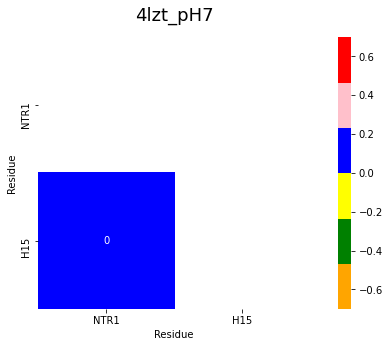

In [8]:
# find the pearson correlation
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
df1 = all_crg_count_corr.corr()
plt.figure(figsize=(10, 5))
# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df1, dtype=np.bool))
cmap = ListedColormap(["orange", "green", "yellow", "blue", "pink", 'red'])
heatmap = sns.heatmap(df1, mask=mask, vmin=-0.7, vmax=0.7, annot=True, cmap=cmap, square = True)
heatmap.set_title('4lzt_pH7', fontdict={'fontsize':18}, pad=16)
plt.savefig("corr_4lzt_pH7_high_occ.pdf", dpi = 600, bbox_inches = 'tight');


In [ ]:
df1